# Assignment 5

## Overview

Dataset 1&2 contain point cloud data storing as a row and column. Each row has 3 values i.e. the x, y, z value for each point.

## Objective

- Process LiDAR datasets with Python
- Apply and tune machine learning methods
- Document everything in your Github folder, using separate commits for each task


## General Requirements

- Commit all code/results/documentation to Github (personal folder)
- Ensure answers/plots for both datasets

## Skills Developed:

- LiDAR data processing with Python
- ML model tuning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(72067, 3)

(84588, 3)

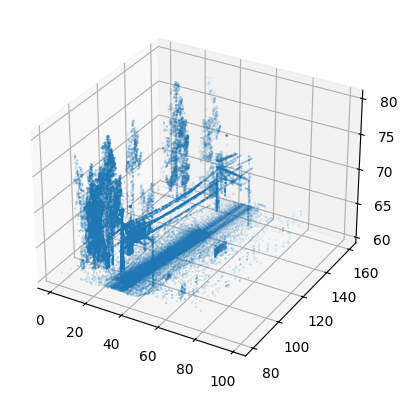

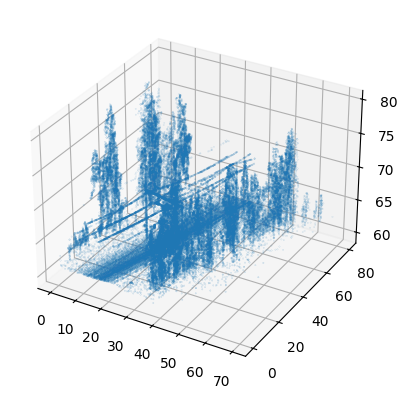

In [52]:
import matplotlib
import numpy as np
from scipy.spatial import KDTree
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#%% utility functions
def show_cloud(points_plt):
    ax = plt.axes(projection='3d')
    ax.scatter(points_plt[:,0], points_plt[:,1], points_plt[:,2], s=0.01)
    plt.show()

def show_scatter(x,y):
    plt.scatter(x, y)
    plt.show()

# Ground level would be continuously collected by LiDAR (sky does not really reflect the LiDAR signals), and ground level is usually lower Z-axis values, so assume the highest peak corresponds to the ground
def get_ground_level(pcd,percent):
    z_coords = pcd[:, 2] # ':' means select all data, '2' means select column 2 data, which is Z-axis data

    # Calculate the Z-coordinate value based on percent
    estimated_ground_level = np.percentile(z_coords, percent)

    # Display the histogram
    plt.figure()
    plt.hist(z_coords, bins=500) # calculate the frequence of Z-axis value, and then split into 500 bins
    plt.title('Histogram of Z-coordinates')
    plt.xlabel('Z-coordinate')
    plt.ylabel('Frequency')
    plt.axvline(estimated_ground_level, color='r', linestyle='dashed', linewidth=2, label=f'{percent}th Percentile: {estimated_ground_level:.2f}')
    plt.legend()
    plt.show()

    return estimated_ground_level


# read file containing point cloud data
from google.colab import drive
from google.colab import userdata
## Update the path to your dataset file in Google Drive
drive.mount('/content/drive')
dataset1 = userdata.get('Assignment5_Dataset1')
dataset2 = userdata.get('Assignment5_Dataset2')

pcd_1 = np.load(dataset1)
pcd_2 = np.load(dataset2)
display(pcd_1.shape)
display(pcd_2.shape)

# using %matplotlib inline instead of qt as it is not supported in Colab environment.
%matplotlib inline
show_cloud(pcd_1)
show_cloud(pcd_2)
# show_cloud(pcd[::10]) # keep every 10th point

#%% remove ground plane

# Task 1: Ground Level Detection

**Goal**: Find the best value for the ground level in the point cloud data.

**Method**: Use a histogram (np.histogram) to help determine the optimal ground level and update the `get_ground_level()` function accordingly.

**Requirements**:

*   For each dataset, report the found ground level in the README file of your GitHub project.
*   Add the histogram plots to the README of your GitHub project.

Data Set 1


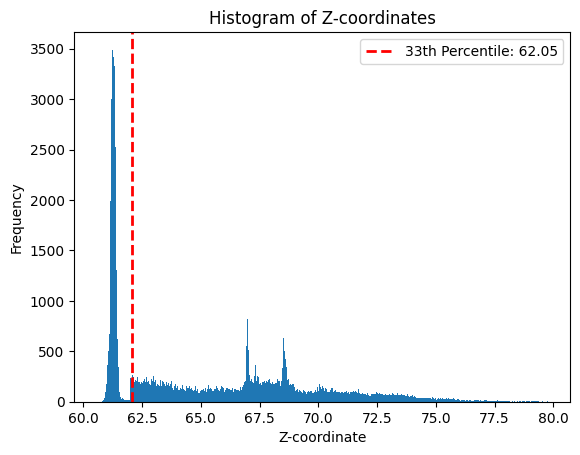

62.053


(48277, 3)

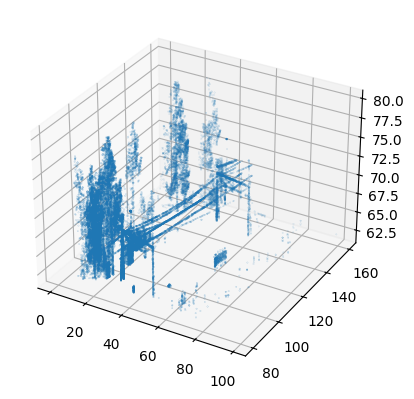

Data Set 2


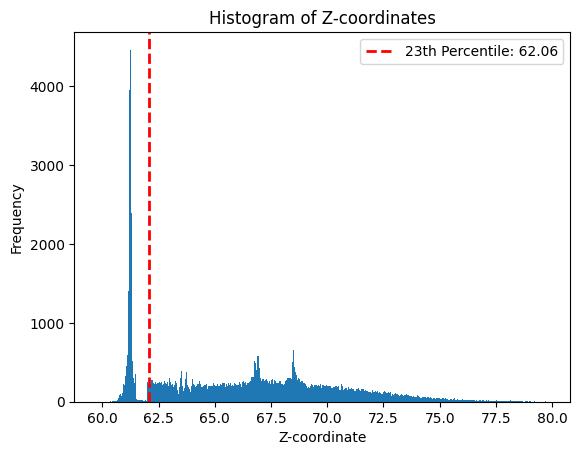

62.06200000000001


(65130, 3)

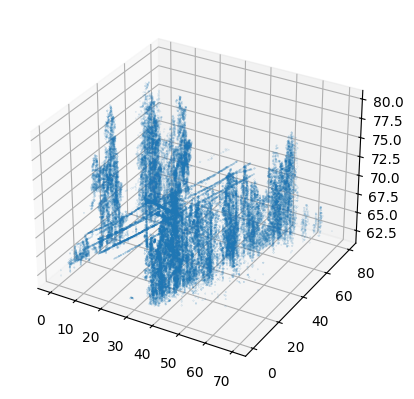

In [53]:
print("Data Set 1")
est_ground_level_1 = get_ground_level(pcd_1,33) # trial and error to find the percentage that has high possibility of being ground level
print(est_ground_level_1)
pcd_above_ground_1 = pcd_1[pcd_1[:,2] > est_ground_level_1]
display(pcd_above_ground_1.shape)
show_cloud(pcd_above_ground_1) # sideview

print("Data Set 2")
est_ground_level_2 = get_ground_level(pcd_2,23) # trial and error to find the percentage that has high possibility of being ground level
print(est_ground_level_2)
pcd_above_ground_2 = pcd_2[pcd_2[:,2] > est_ground_level_2]
display(pcd_above_ground_2.shape)
show_cloud(pcd_above_ground_2) # sideview


# Task 2: DBSCAN Clustering (Optimal Eps)

**Goal**: Find an optimized value for the `eps` parameter for DBSCAN clustering.

**Method**:
*   Plot an elbow curve to help determine the optimal `eps` value.
*   Extract the optimal value from the elbow plot.
*   Apply DBSCAN again with the new `eps` value.

**Requirements**:

*   For both datasets, report the optimal `eps` value in the README of your GitHub project.
*   Add the elbow plots to the README of your GitHub project.
*   Add the cluster plots (using the optimized `eps`) to the README of your GitHub project.

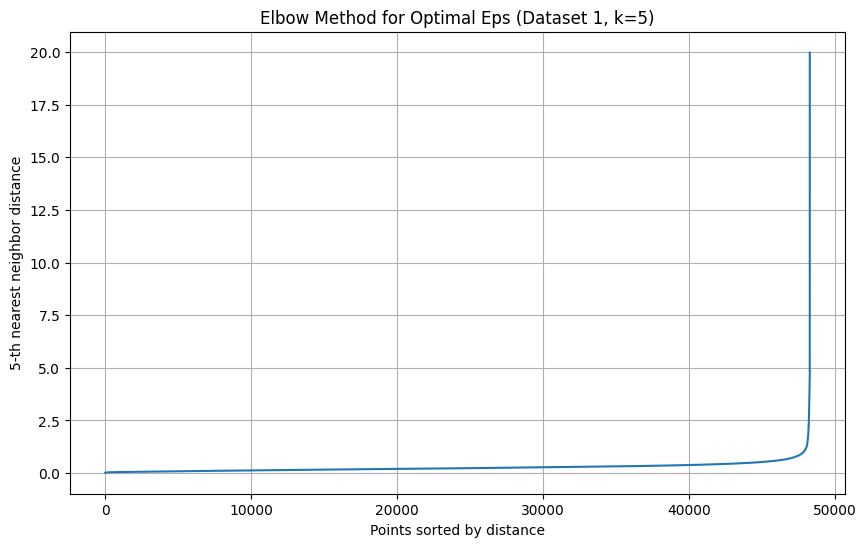

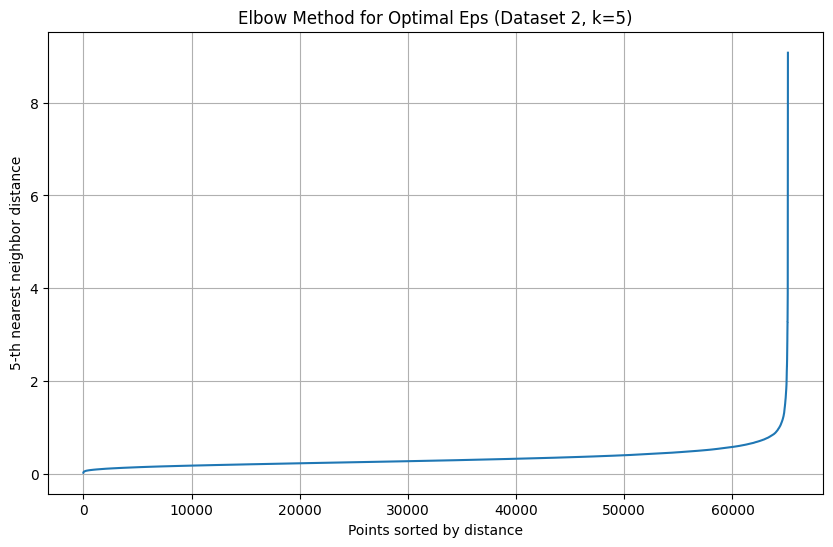

In [58]:
from sklearn.neighbors import NearestNeighbors

# Define k (which should be your min_samples for DBSCAN)
k = 5

# Calculate the k-th nearest neighbor distances for dataset 1
neigh1 = NearestNeighbors(n_neighbors=k)
neigh1.fit(pcd_above_ground_1) # builds an internal data structure that makes finding neighbors efficient.
distances1, indices1 = neigh1.kneighbors(pcd_above_ground_1) # perform the search for nearest neighbors. in this case, it will search all data in pcd_above_1.

# Sort the distances and plot
distances1 = np.sort(distances1[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances1)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.title(f'Elbow Method for Optimal Eps (Dataset 1, k={k})')
plt.grid(True)
plt.show()

# Calculate the k-th nearest neighbor distances for dataset 2
neigh2 = NearestNeighbors(n_neighbors=k)
neigh2.fit(pcd_above_ground_2)
distances2, indices2 = neigh2.kneighbors(pcd_above_ground_2)

# Sort the distances and plot
distances2 = np.sort(distances2[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances2)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.title(f'Elbow Method for Optimal Eps (Dataset 2, k={k})')
plt.grid(True)
plt.show()

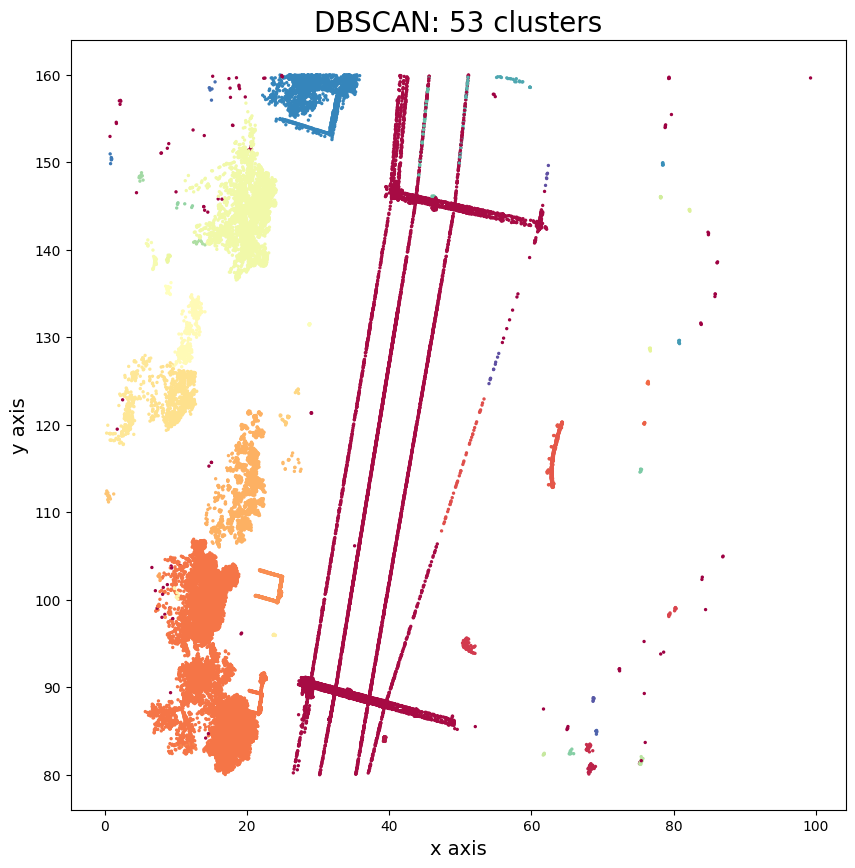

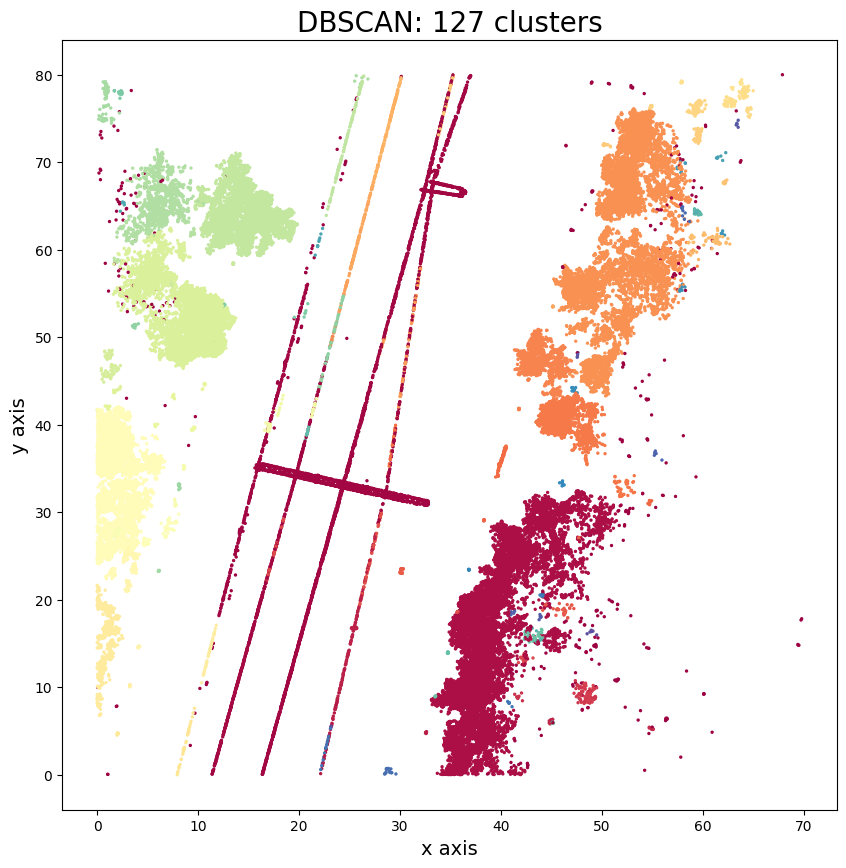

In [66]:
# Dataset 1
optimal_eps_1 = 1.25
# find the elbow
clustering_1 = DBSCAN(eps = optimal_eps_1, min_samples=5).fit(pcd_above_ground_1)

#%%
clusters = len(set(clustering_1.labels_)) - (1 if -1 in clustering_1.labels_ else 0)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, clusters)]

# %%
# Plotting resulting clusters
plt.figure(figsize=(10,10))
plt.scatter(pcd_above_ground_1[:,0],
            pcd_above_ground_1[:,1],
            c=clustering_1.labels_,
            cmap=matplotlib.colors.ListedColormap(colors),
            s=2)
plt.title('DBSCAN: %d clusters' % clusters,fontsize=20)
plt.xlabel('x axis',fontsize=14)
plt.ylabel('y axis',fontsize=14)
plt.show()

# Dataset 2
optimal_eps_2 = 1
# find the elbow
clustering_2 = DBSCAN(eps = optimal_eps_2, min_samples=5).fit(pcd_above_ground_2)

#%%
clusters = len(set(clustering_2.labels_)) - (1 if -1 in clustering_2.labels_ else 0)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, clusters)]

# %%
# Plotting resulting clusters
plt.figure(figsize=(10,10))
plt.scatter(pcd_above_ground_2[:,0],
            pcd_above_ground_2[:,1],
            c=clustering_2.labels_,
            cmap=matplotlib.colors.ListedColormap(colors),
            s=2)
plt.title('DBSCAN: %d clusters' % clusters,fontsize=20)
plt.xlabel('x axis',fontsize=14)
plt.ylabel('y axis',fontsize=14)
plt.show()